# IMC deconvolution based on overlapping ablation PSF

WORKFLOW:

Prerequisite: run the decay estimation to obtain the decay function with selected laser power.

1. Evaluation of PSF, either 333 nm or 500 nm.
2. Image preprocessing and deconvolution: hot pixel filtering -> pixel overlapping -> dynamic-range-selected RL deconvolution

In [1]:
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from tifffile import imread, imwrite
from scipy.ndimage import gaussian_filter
from skimage.restoration import richardson_lucy
from skimage.util import img_as_uint, img_as_float32
import cv2
from readimc import MCDFile, TXTFile
%matplotlib inline

In [2]:
work_dir = os.getcwd()
    
exp_name = "20250422_QH_eGFP_RCA_in_vivo_IMC"
data_dir = "/mnt/central_nas/users/ychian/Exp/202503_IMC_inten_encoding/20250426_eGFP_in_vivo_RCA_2nd"
input_dir = os.path.join(data_dir, 'tif')
output_dir = os.path.join(os.path.dirname(input_dir), exp_name+"_decov")

psf_dir = os.path.join(data_dir, "psf")

# create psf directory if it doesn't exist
if not os.path.exists(psf_dir):
    os.makedirs(psf_dir)

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

## Read in metadata dataframe for selective deconvolution

In [3]:
df_list = [f for f in os.listdir(data_dir) if f.endswith('.xlsx')]
df = pd.read_excel(os.path.join(data_dir, df_list[0]))
# set the data type of the columns
df = df.astype({'file_name': 'str', 'image_decay': 'str', 'resolution': 'float', 'power': 'int', 'shot': 'int', 'rep': 'int', 'id': 'str', 'cond': 'str'})

## PSF simulator

### Define functions

Decay function is evaluate using the same dataset, 1um ablation with different powers. Nuclear segmenation was performed and intensity statistic in the masked Iridium channel was estimated.

In [43]:
decay_coeff_dir = os.path.join(data_dir, "decay_coeff")
decay_file_name = "193Ir_intensity_decay_-10db_masked_fitting_poly.csv"
# read in decay coefficient from csv
decay_df = pd.read_csv(os.path.join(decay_coeff_dir, decay_file_name))
# decay_df = 7

In [44]:
# def pass_decay(I0, nop, decay_coeff):
#     return I0 - I0/(1+ np.exp(-(nop - decay_coeff)))

def pass_decay(I0, nop, decay_coeff):
    degree = decay_coeff['degree'][0]
    p = np.array(decay_coeff['coefficients'][0].strip('[]').split()).astype(float)
    # normalized p so that sum(p) = 1
    p = p / np.sum(p)
    
    return np.polyval(p, nop)

In [45]:
pass_decay(1, 1, decay_df)

np.float64(1.0000000000000009)

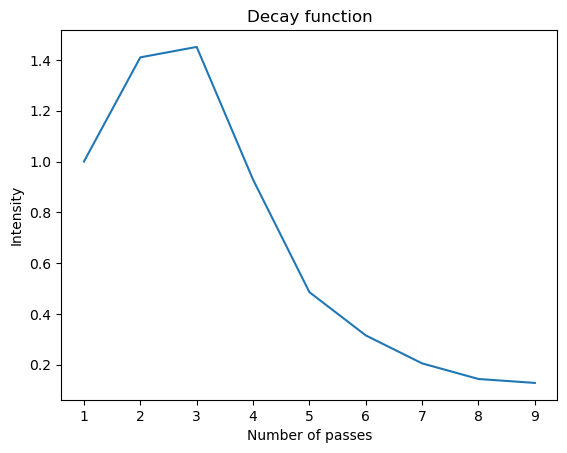

In [47]:
# plot decay function
nop = np.arange(1, 10)
plt.plot(nop, pass_decay(1, nop, decay_df))
plt.xlabel('Number of passes')
plt.ylabel('Intensity')
plt.title('Decay function')
plt.show()

Define other functions

In [48]:

def show_mask(mask, colim):
    plt.imshow(mask, cmap='gray')
    # flip the x,y axis
    plt.colorbar()
    plt.clim(0, colim)
    plt.show()

def find_pixel_in_radius(light_mask, x, y, radius, pixel_size):
    # return the mask which is included in the radius and not within x-pixel_size//2, x+pixel_size//2, y-pixel_size//2, y+pixel_size//2
    ablat_mask = np.zeros_like(light_mask)
    for i in range(light_mask.shape[0]):
        for j in range(light_mask.shape[1]):
            if (i - x)**2 + (j - y)**2 <= radius**2 and light_mask[i, j] == 1:
                ablat_mask[i, j] = 1
    return ablat_mask

def add_ablation_to_mask(ablated_mask, ablat_mask):
    # add ablation to the mask
    ablated_mask = ablated_mask + ablat_mask
    return ablated_mask

def psf_evolve(psf, decay_coeff, light_mask, ablated_mask, x, y, radius, overlap, plot_all=False):
    pixel_size = radius*2//overlap
    ablat_mask = find_pixel_in_radius(light_mask, x, y, radius, pixel_size)
    ablated_mask = add_ablation_to_mask(ablated_mask, ablat_mask)

    size_mask = ablated_mask.shape[0]
    # count the number of pixels in the ablat_mask
    source_count = np.sum(ablat_mask)
    target_count = (2*radius)**2
    # calculate the signal from source
    ablated_mask_shot = pass_decay(1, ablated_mask, decay_coeff) * ablated_mask

    # sum up the signal from source
    source_signal = np.sum(ablated_mask_shot)
    # calculate the signal from target
    target_signal = source_signal / target_count
    # print('target_signal', target_signal)
    psf[x - radius:x + radius, y - radius:y + radius] = psf[x - radius:x + radius, y - radius:y + radius] + target_signal

    
    if plot_all:
        print('ablat_mask')
        show_mask(ablat_mask, 1)
        print('ablated_mask')
        show_mask(ablated_mask, np.max(ablated_mask))
        print('ablated_mask_shot')
        show_mask(ablated_mask_shot, np.max(ablated_mask_shot))
        print('psf')
        show_mask(psf, np.max(psf))
    return psf, ablated_mask

def psf_non_ov_evolve(psf, decay_coeff, light_mask, ablated_mask, x, y, radius, overlap, plot_all=False):
    pixel_size = radius*2//overlap
    ablat_mask = find_pixel_in_radius(light_mask, x, y, radius, pixel_size)
    ablated_mask = add_ablation_to_mask(ablated_mask, ablat_mask)

    size_mask = ablated_mask.shape[0]
    # count the number of pixels in the ablat_mask
    source_count = np.sum(ablat_mask)
    target_count = (2*radius)**2
    # calculate the signal from source
    ablated_mask_shot = pass_decay(1, ablated_mask, decay_coeff) * ablated_mask

    # sum up the signal from source
    source_signal = np.sum(ablated_mask_shot)
    # calculate the signal from target
    target_signal = source_signal / target_count
    # print('target_signal', target_signal)
    # psf[x - radius:x + radius, y - radius:y + radius] = psf[x - radius:x + radius, y - radius:y + radius] + target_signal
    psf[x-pixel_size//2:x+pixel_size//2, y-pixel_size//2:y+pixel_size//2] = psf[x-pixel_size//2:x+pixel_size//2, y-pixel_size//2:y+pixel_size//2] + target_signal
    
    if plot_all:
        print('ablat_mask')
        show_mask(ablat_mask, 1)
        print('ablated_mask')
        show_mask(ablated_mask, np.max(ablated_mask))
        print('ablated_mask_shot')
        show_mask(ablated_mask_shot, np.max(ablated_mask_shot))
        print('psf')
        show_mask(psf, np.max(psf))
    return psf, ablated_mask

### 300nm PSF

In [49]:
# initialize
psf = np.zeros((500, 500))

decay_coeff = decay_df # a polynomial fitted decay function

light_mask = np.zeros_like(psf)
light_mask[200:300, 200:300] = 1
output = np.zeros_like(psf)

ablated_mask = np.zeros_like(psf)

ablation_shot = np.array([(150, 150), (250, 150), (350, 150), (150, 250), (250, 250), (350, 250), (150, 350), (250, 350), (350, 350)])

x: 150 y: 150
ablat_mask


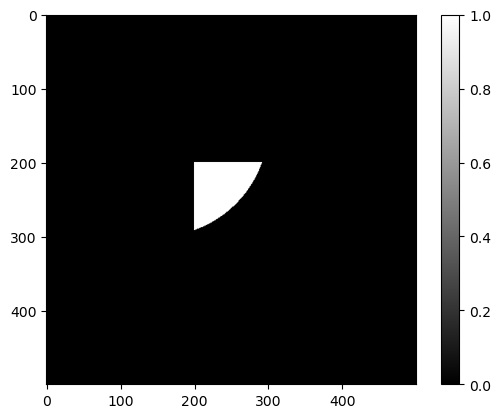

ablated_mask


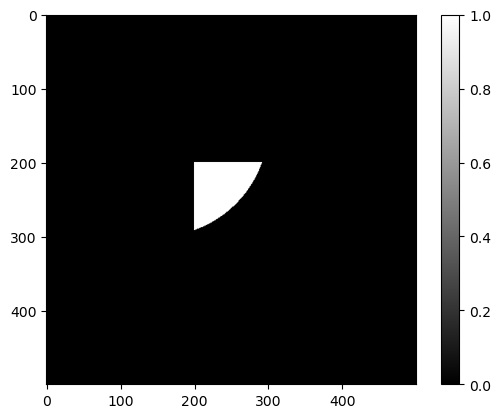

ablated_mask_shot


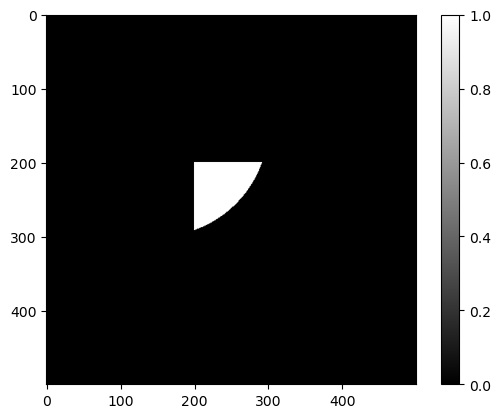

psf


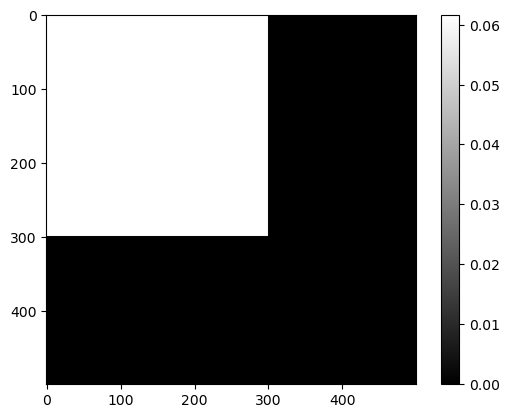

x: 250 y: 150
ablat_mask


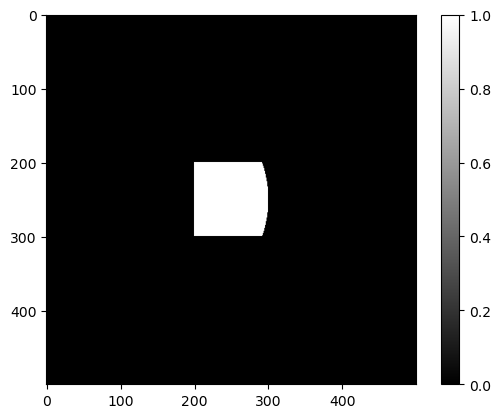

ablated_mask


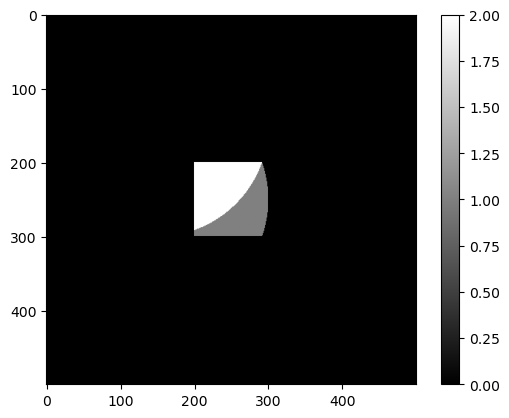

ablated_mask_shot


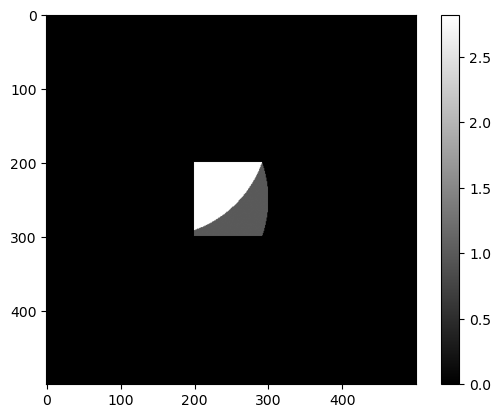

psf


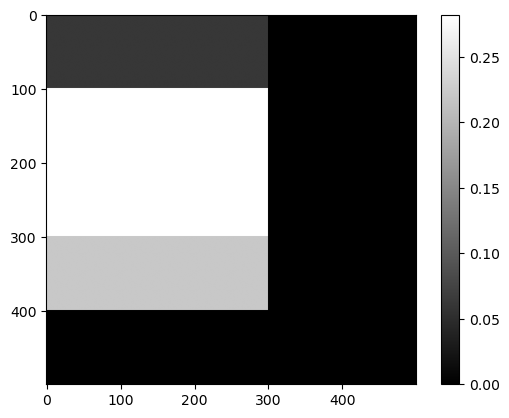

x: 350 y: 150
ablat_mask


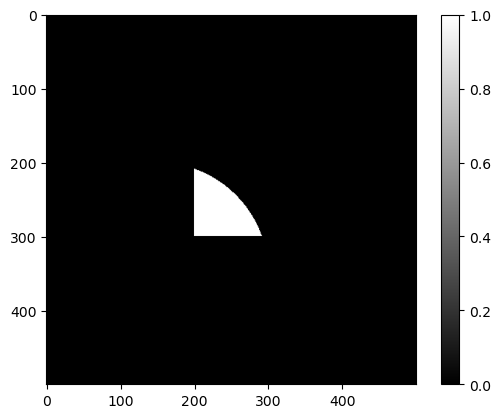

ablated_mask


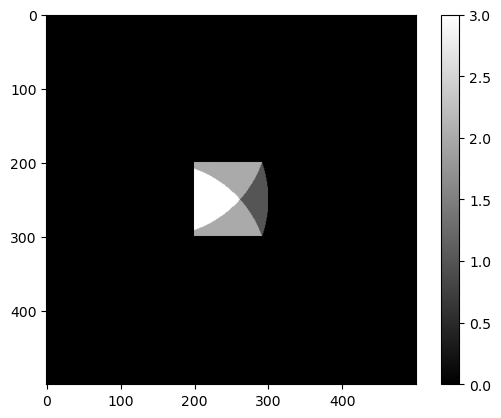

ablated_mask_shot


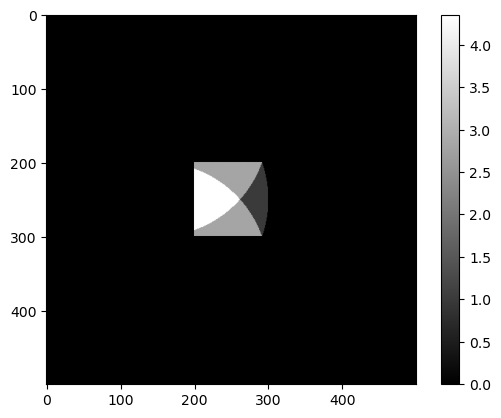

psf


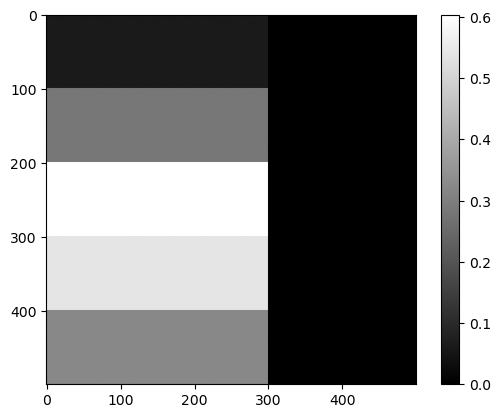

x: 150 y: 250
ablat_mask


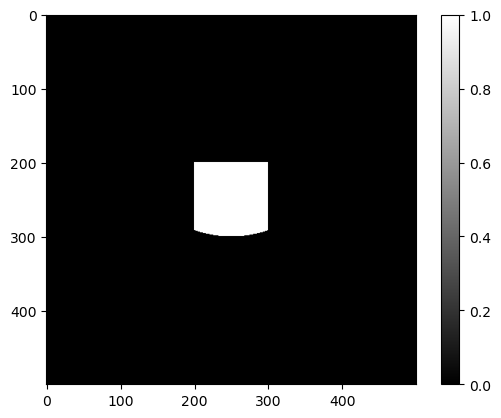

ablated_mask


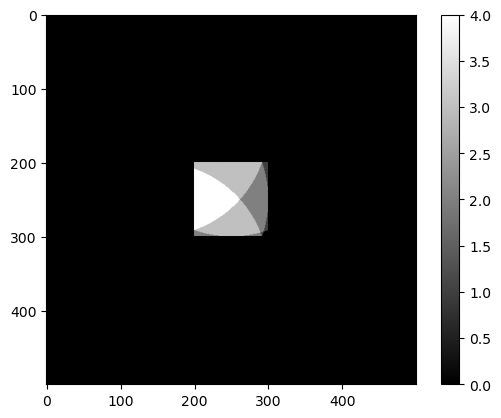

ablated_mask_shot


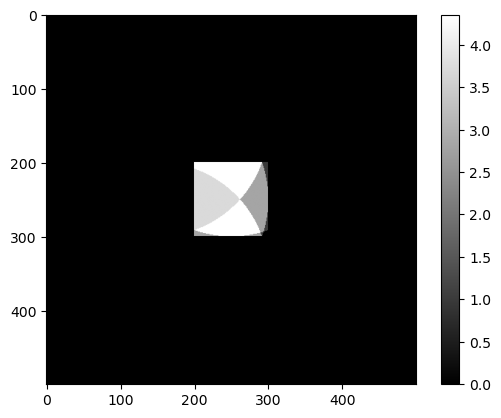

psf


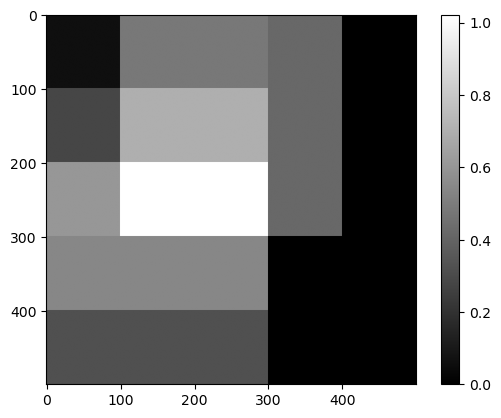

x: 250 y: 250
ablat_mask


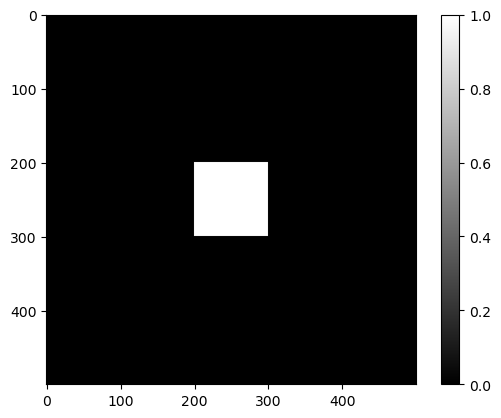

ablated_mask


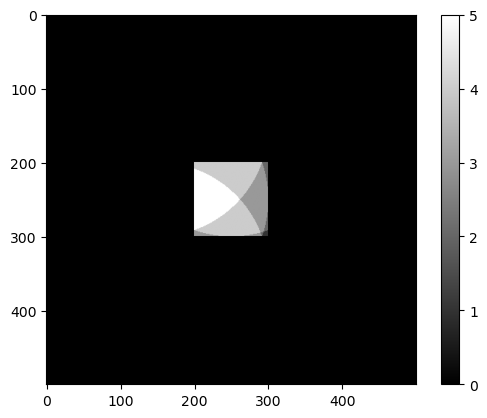

ablated_mask_shot


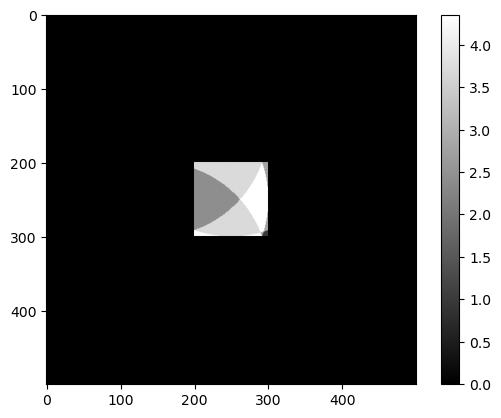

psf


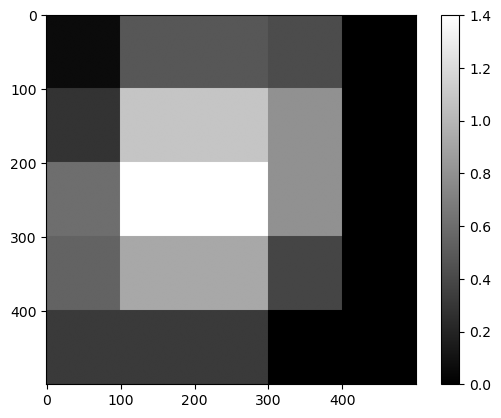

x: 350 y: 250
ablat_mask


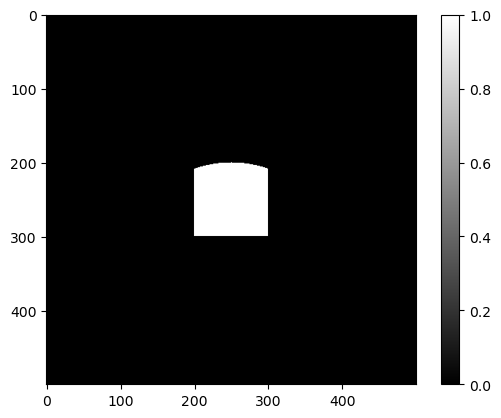

ablated_mask


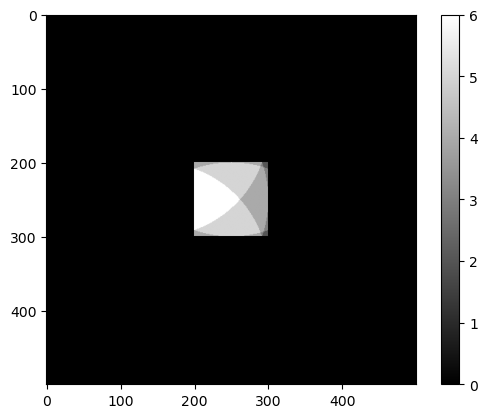

ablated_mask_shot


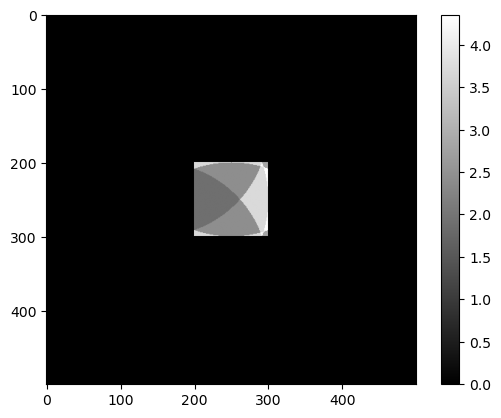

psf


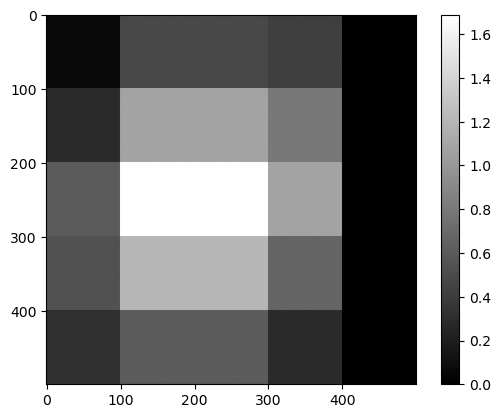

x: 150 y: 350
ablat_mask


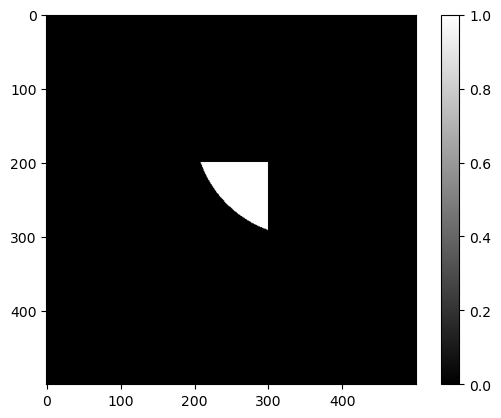

ablated_mask


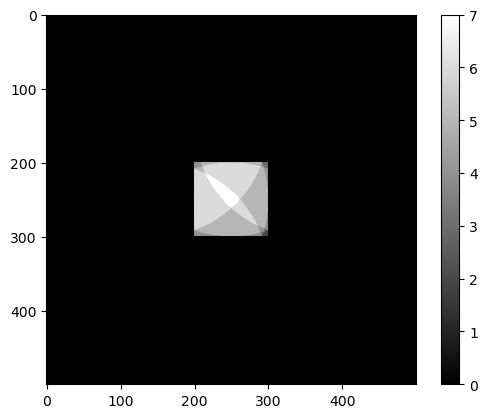

ablated_mask_shot


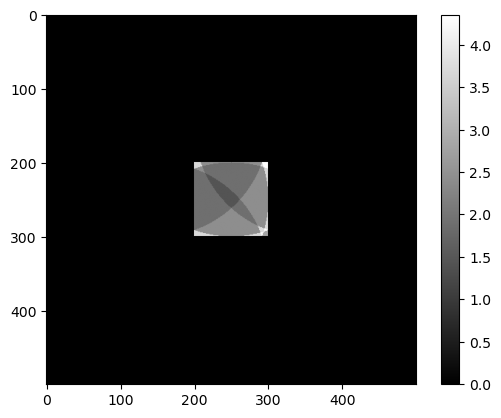

psf


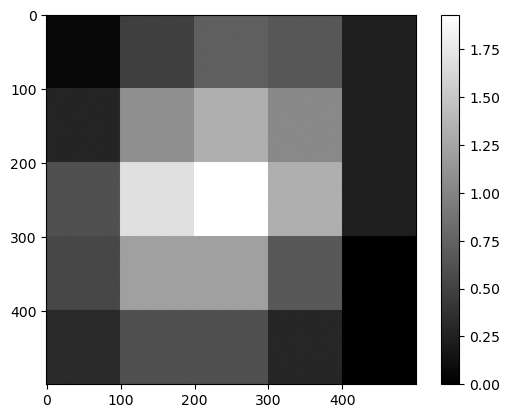

x: 250 y: 350
ablat_mask


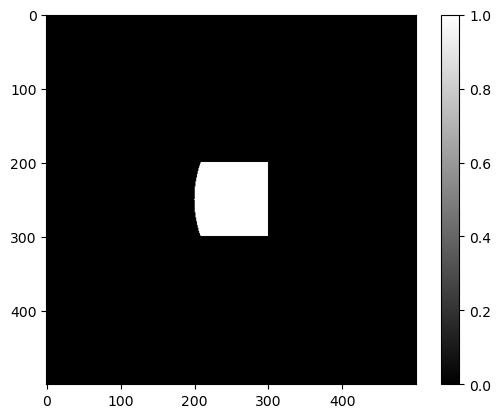

ablated_mask


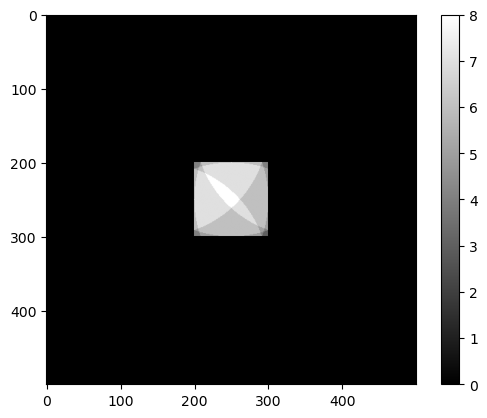

ablated_mask_shot


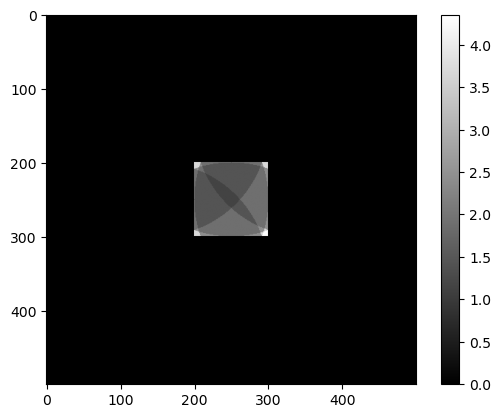

psf


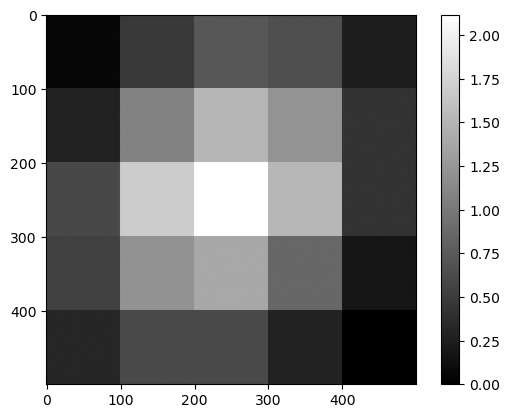

x: 350 y: 350
ablat_mask


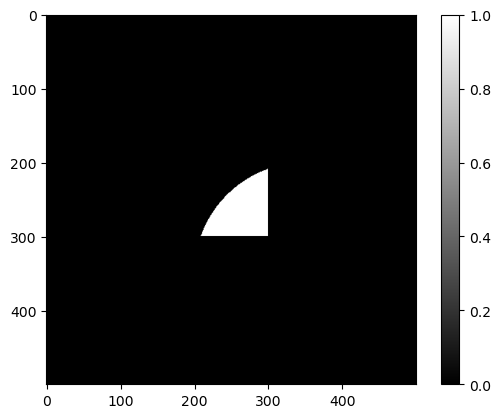

ablated_mask


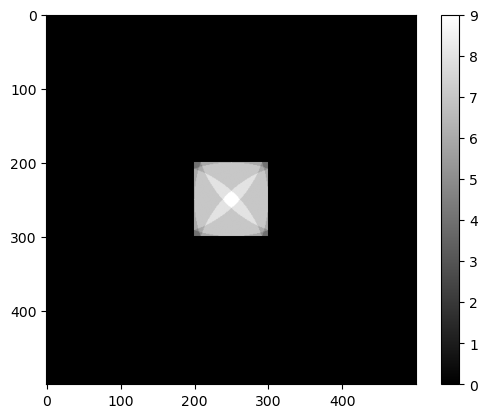

ablated_mask_shot


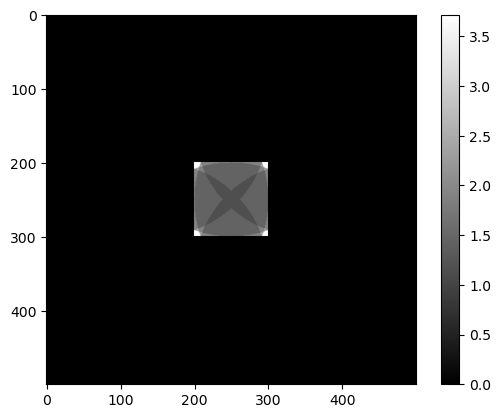

psf


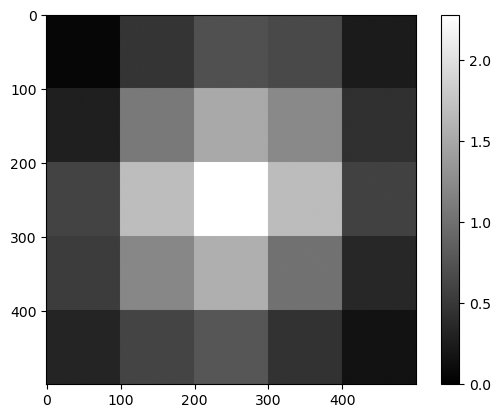

In [50]:
# start ablation
for i in range(len(ablation_shot)):
    x, y = ablation_shot[i]
    print('x:', x, 'y:', y)
    psf, ablated_mask = psf_evolve(psf, decay_coeff, light_mask, ablated_mask, x, y, 150, 3, True)
    # psf, ablated_mask = psf_non_ov_evolve(psf, decay_coeff, light_mask, ablated_mask, x, y, 150, 3, True)

Normalize and downsample to proper kernel size

In [51]:
# do normalization to sum to 1
psf = psf / np.sum(psf)

In [52]:
# down sample to 5x5
psf_dn = np.zeros((5,5))

for i in range(5):
    for j in range(5):
        psf_dn[i, j] = np.sum(psf[i*100:(i+1)*100, j*100:(j+1)*100])
        
psf_dn = psf_dn / np.sum(psf_dn)


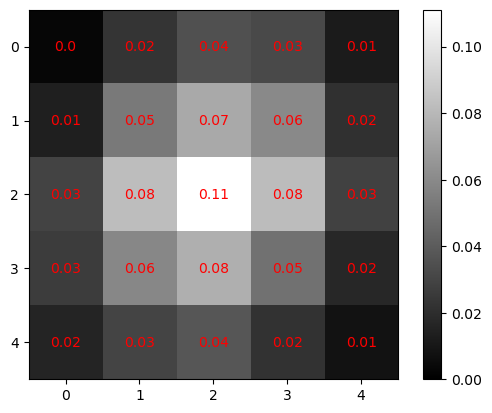

In [53]:
# plot a 3d plot, make it interactive
# show image with value on each pixel
fig = plt.figure()
plt.imshow(psf_dn, cmap='gray')
plt.colorbar()
plt.clim(0, np.max(psf_dn))
# print the value on each pixel
for i in range(psf_dn.shape[0]):
    for j in range(psf_dn.shape[1]):
        plt.text(j, i, str(round(psf_dn[i, j], 2)), ha='center', va='center', color='red')
plt.show()


In [54]:
# transpose the psf so that it matches the ablation pattern
psf_dn = psf_dn.T

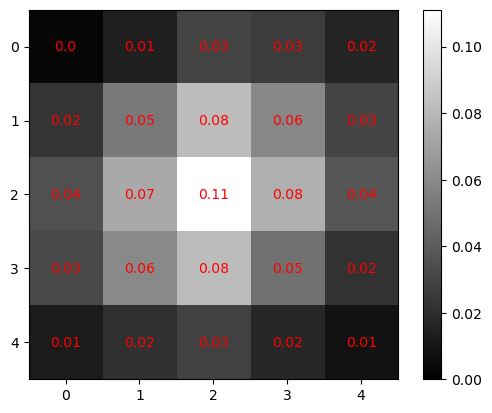

In [55]:
fig = plt.figure()
plt.imshow(psf_dn, cmap='gray')
plt.colorbar()
plt.clim(0, np.max(psf_dn))
# print the value on each pixel
for i in range(psf_dn.shape[0]):
    for j in range(psf_dn.shape[1]):
        plt.text(j, i, str(round(psf_dn[i, j], 2)), ha='center', va='center', color='red')
plt.show()

In [58]:
# save the psf as tiff with float value
imwrite(os.path.join(psf_dir, 'psf_300_-10db.tif'), img_as_float32(psf_dn))

### 500nm PSF

In [13]:
# initialize
psf = np.zeros((300, 300))

decay_coeff = decay_df # a polynomial fitted decay function

light_mask = np.zeros_like(psf)
light_mask[100:200, 100:200] = 1
output = np.zeros_like(psf)

ablated_mask = np.zeros_like(psf)

ablation_shot = np.array([(100, 100), (200, 100), (100, 200), (200, 200)])

x: 100 y: 100
ablat_mask


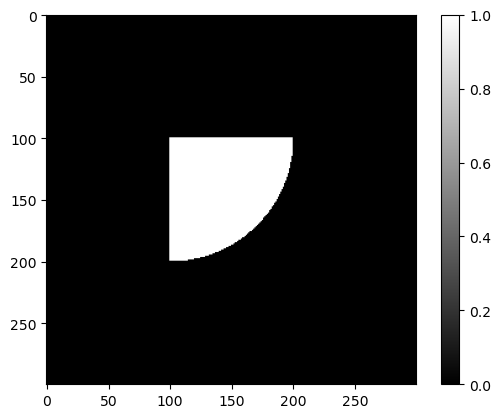

ablated_mask


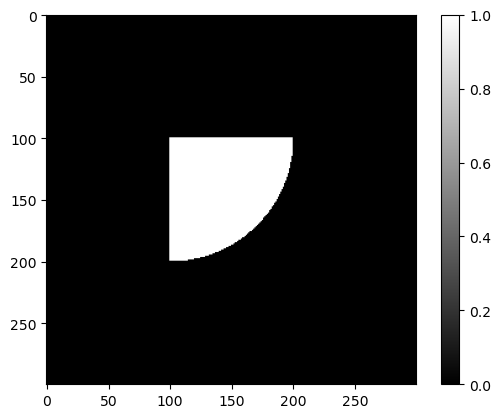

ablated_mask_shot


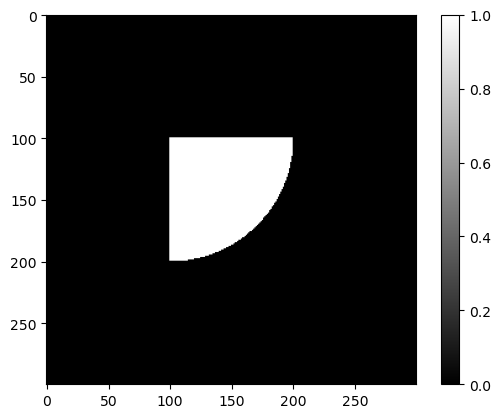

psf


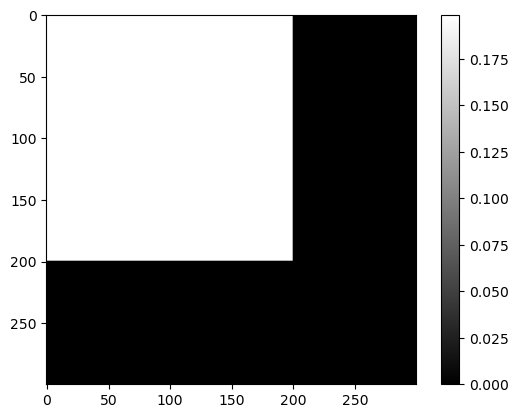

x: 200 y: 100
ablat_mask


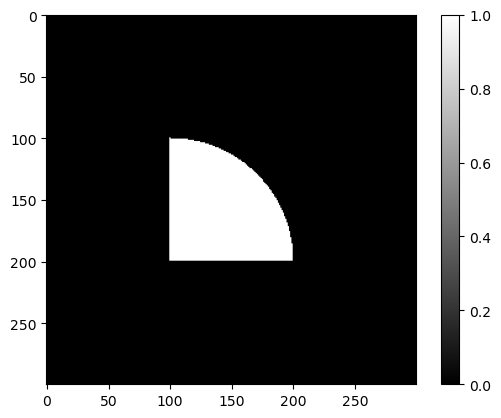

ablated_mask


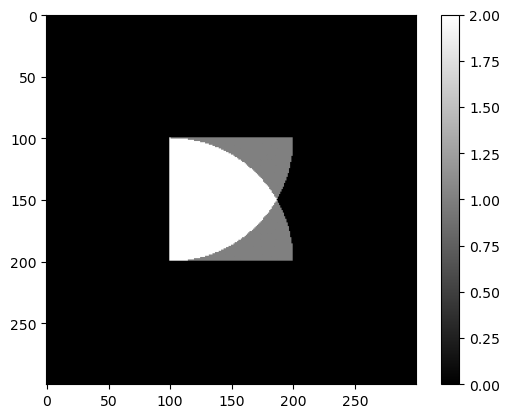

ablated_mask_shot


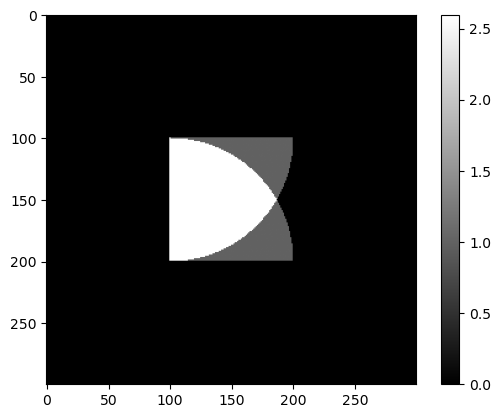

psf


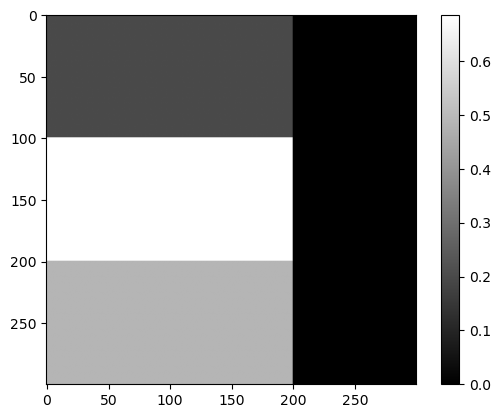

x: 100 y: 200
ablat_mask


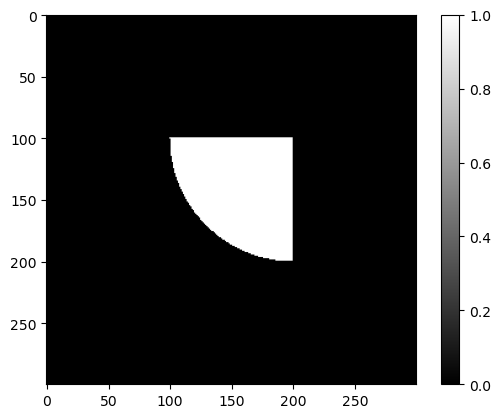

ablated_mask


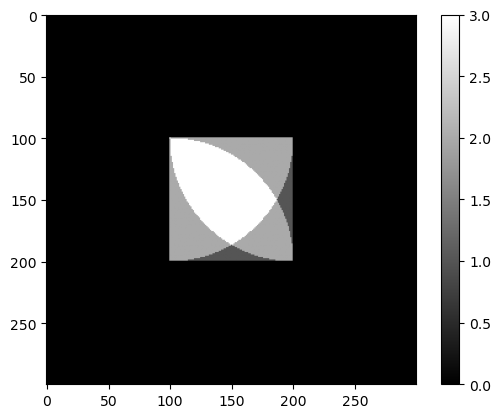

ablated_mask_shot


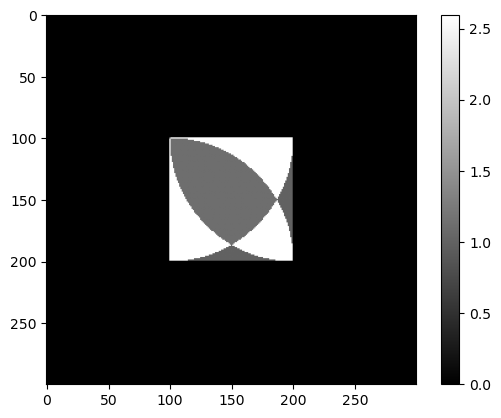

psf


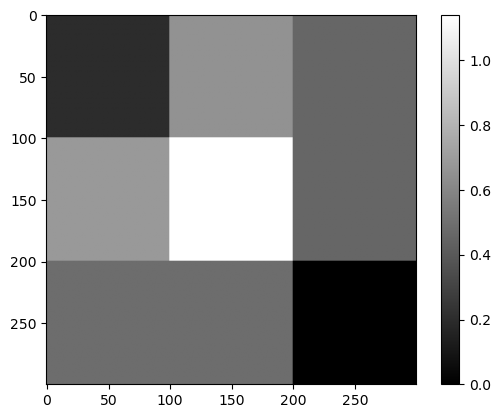

x: 200 y: 200
ablat_mask


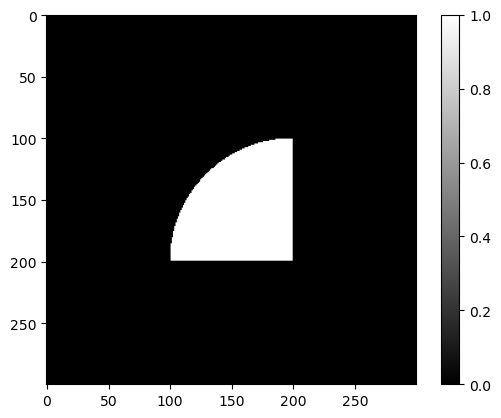

ablated_mask


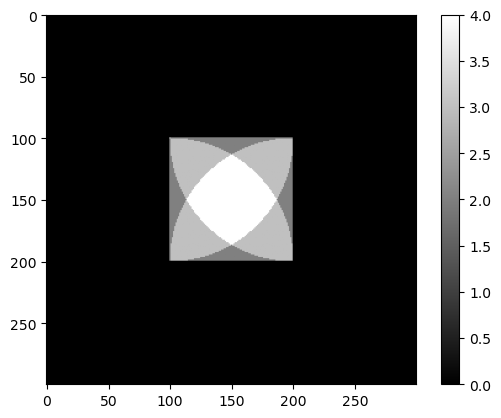

ablated_mask_shot


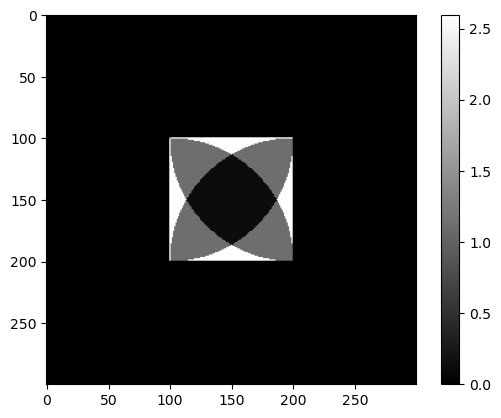

psf


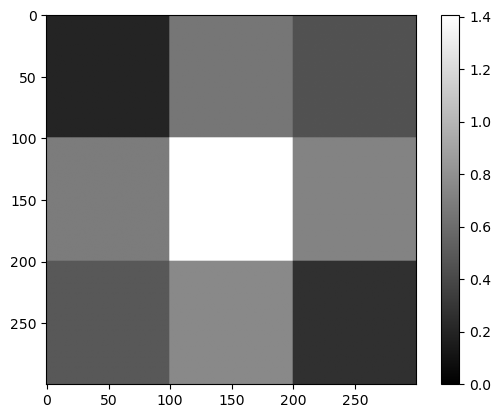

In [14]:
# start ablation
for i in range(len(ablation_shot)):
    x, y = ablation_shot[i]
    print('x:', x, 'y:', y)
    psf, ablated_mask = psf_evolve(psf, decay_coeff, light_mask, ablated_mask, x, y, 100, 2, True)

In [15]:
# do normalization to sum to 1
psf = psf / np.sum(psf)

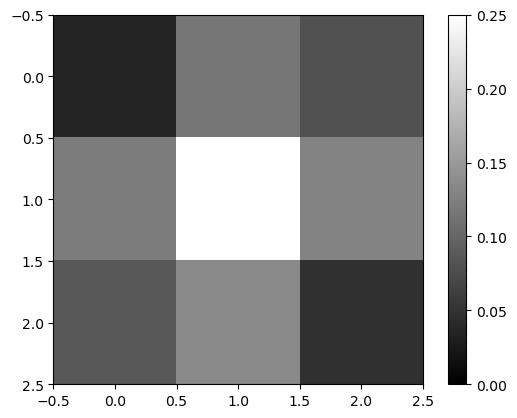

In [16]:
# down sample to 5x5
psf_dn = np.zeros((3,3))

for i in range(3):
    for j in range(3):
        psf_dn[i, j] = np.sum(psf[i*100:(i+1)*100, j*100:(j+1)*100])
        
psf_dn = psf_dn / np.sum(psf_dn)

# show the psf
show_mask(psf_dn, np.max(psf_dn))


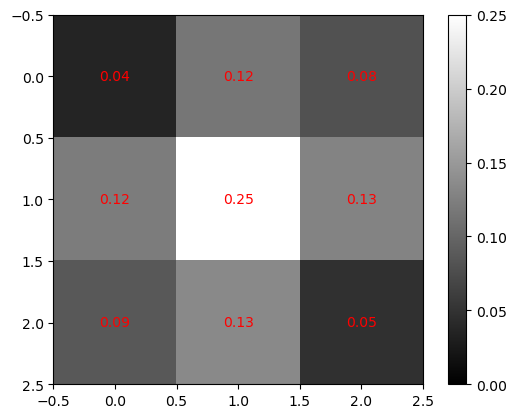

In [17]:
# plot a 3d plot, make it interactive
# show image with value on each pixel
fig = plt.figure()
plt.imshow(psf_dn, cmap='gray')
plt.colorbar()
plt.clim(0, np.max(psf_dn))
# print the value on each pixel
for i in range(psf_dn.shape[0]):
    for j in range(psf_dn.shape[1]):
        plt.text(j, i, str(round(psf_dn[i, j], 2)), ha='center', va='center', color='red')
plt.show()


In [21]:
# transpose the psf so that it matches the ablation pattern
psf_dn = psf_dn.T

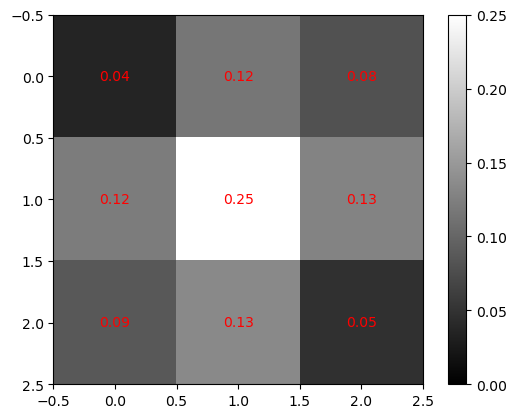

In [18]:
fig = plt.figure()
plt.imshow(psf_dn, cmap='gray')
plt.colorbar()
plt.clim(0, np.max(psf_dn))
# print the value on each pixel
for i in range(psf_dn.shape[0]):
    for j in range(psf_dn.shape[1]):
        plt.text(j, i, str(round(psf_dn[i, j], 2)), ha='center', va='center', color='red')
plt.show()

In [20]:
# save the psf as tiff with float value
imwrite(os.path.join(psf_dir, 'psf_500_-5db.tif'), img_as_float32(psf_dn))

## Deconvolution

### Define workflow

In [6]:
def hot_pix_filtering(scan_data, hot_threshold):
    # for each pixel, if the value is > int_threshold than the max value of the surrounding 8 pixels, set it to the max value of the surrounding 8 pixels
    for layer in range(scan_data.shape[0]):
        hot_count = 0
        for x in range(1, scan_data.shape[1]-1):
            for y in range(1, scan_data.shape[2]-1):
                # find the max of the surrounding 8 pixels
                # exclude the center pixel
                ring_kernel = np.array([[1,1,1], [1,0,1], [1,1,1]])
                ring_max = np.max(scan_data[layer, x-1:x+2, y-1:y+2][ring_kernel == 1])
                if scan_data[layer, x, y] - ring_max > hot_threshold:
                    hot_count += 1
                    scan_data[layer, x, y] = ring_max
        print('Layer:', layer, ' / Hot pixel count:', hot_count)
    return scan_data

def raw_to_olp(scan_data, overlap):
    if overlap == 3:
        scan_data_olp = np.zeros((scan_data.shape[0], scan_data.shape[1]+2, scan_data.shape[2]+2))
        # fill the array with the original data
        for layer in range(scan_data.shape[0]):
            for x in range(scan_data.shape[1]):
                for y in range(scan_data.shape[2]):
                    scan_data_olp[layer, x+1-overlap//2:x+1+overlap//2+1, y+1-overlap//2:y+1+overlap//2+1] = scan_data_olp[layer, x+1-overlap//2:x+1+overlap//2+1, y+1-overlap//2:y+1+overlap//2+1] + scan_data[layer, x, y]
    elif overlap == 2:
        scan_data_olp = np.zeros((scan_data.shape[0], scan_data.shape[1]+1, scan_data.shape[2]+1))
        # fill the array with the original data
        for layer in range(scan_data.shape[0]):
            for x in range(scan_data.shape[1]):
                for y in range(scan_data.shape[2]):
                    scan_data_olp[layer, x+1-overlap//2:x+1+overlap//2, y+1-overlap//2:y+1+overlap//2] = scan_data_olp[layer, x+1-overlap//2:x+1+overlap//2, y+1-overlap//2:y+1+overlap//2] + scan_data[layer, x, y]
    else:
        # stop report error
        print('Error: overlap should be 2 or 3')
        return None
    return scan_data_olp

def RLD_HRIMC_circle(input_dir, output_dir, img_list, psf_dn_name, kernel, overlap, layer_int_max, hot_threshold, iterations):
    # Ensure the output directory exists
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    # Loop through all TIFF files in the input directory
    for filename in img_list:
        if filename.endswith(".tiff") or filename.endswith(".tif"):
            print("Processing file:", filename)
            # if olp file exists, skip
            olp_dir = os.path.join(output_dir, psf_dn_name.replace(".tif", "_olp"))
            if os.path.exists(os.path.join(olp_dir, filename.replace(".tif", "_olp.tif"))):
                print('File exists:', filename.replace(".tif", "_olp.tif"))
                print('Directly read olp file and start deconvolution')
                scan_data_olp = imread(os.path.join(olp_dir, filename.replace(".tif", "_olp.tif")))
            else:
                # Read the TIFF file
                tiff_path = os.path.join(input_dir, filename)
                scan_data = imread(tiff_path)
                # hot pixel filtering
                scan_data = hot_pix_filtering(scan_data, hot_threshold)
                # create overlapping pixel image for deconvolution
                scan_data_olp = raw_to_olp(scan_data, overlap)

                # save the hot pixel filtered image
                # if the same file name exists, do not save
                hp_dir = os.path.join(output_dir, psf_dn_name.replace(".tif", "_hp"))
                if not os.path.exists(hp_dir):
                    os.makedirs(hp_dir)
                if os.path.exists(os.path.join(hp_dir, filename.replace(".tif", "_hp.tif"))):
                    print('File exists:', filename.replace(".tif", "_hp.tif"))
                else:
                    imwrite(os.path.join(hp_dir, filename.replace(".tif", "_hp.tif")), img_as_float32(scan_data))
                # save the overlapping pixel image
                # if the same file name exists, do not save
                olp_dir = os.path.join(output_dir, psf_dn_name.replace(".tif", "_olp"))
                if not os.path.exists(olp_dir):
                    os.makedirs(olp_dir)
                if os.path.exists(os.path.join(olp_dir, filename.replace(".tif", "_olp.tif"))):
                    print('File exists:', filename.replace(".tif", "_olp.tif"))
                else:
                    imwrite(os.path.join(olp_dir, filename.replace(".tif", "_olp.tif")), img_as_float32(scan_data_olp))
            
            # Normalize each layer of the TIFF and apply transformations
            processed_layers = []
            original_layers = []
            for layer in range(scan_data_olp.shape[0]):
                layer_data = scan_data_olp[layer, :, :]
            
                # Normalize the data between 0 and 1
                # RL algorithm requires the data to be in the range of -1 and 1, otherwise it will be clipped
                # layer_data = (layer_data - layer_data.min()) / (layer_data.max() - layer_data.min())
                # Try normalize using channel-dependent max instead of min max 
                layer_data = (layer_data - np.min(layer_data)) / layer_int_max[layer]
                  
                layer_data_denoise = layer_data
                #Clip values to remove 0s (handled badly by RLD)
                layer_data_denoise = np.clip(layer_data_denoise, 1e-4, None)
                
                # Richardson-Lucy deconvolution
                deconvolved_image = richardson_lucy(layer_data_denoise, kernel, iterations)
                
                # Convert to 16-bit
                # deconvolved_image_uint16 = img_as_uint(deconvolved_image)
                # check with raw value
                deconvolved_image_uint16 = deconvolved_image * layer_int_max[layer]
                processed_layers.append(deconvolved_image_uint16)
                original_layers.append(layer_data_denoise)
            # Stack all processed layers into a single multi-layer TIFF
            processed_tiff = np.stack(processed_layers, axis=0)
            # scan_data = np.stack(scan_data, axis=0)
            
            #Removing a 2 pixel (1um), border to account for border effect (remove if necessary)
            processed_tiff_cropped = processed_tiff[:, (overlap-1):-(overlap-1), (overlap-1):-(overlap-1)]
            
            # Save the processed TIFF to the output directory
            # create folder 
            output_folder = os.path.join(output_dir, psf_dn_name.replace('.tif', '')+"_i"+str(iterations))
            if not os.path.exists(output_folder):
                os.makedirs(output_folder)
            output_path = os.path.join(output_folder, filename.replace(".tif", "_deconvoluted.tif"))
            imwrite(output_path, processed_tiff_cropped)
    
    print(f"Processing complete. Files saved in {output_dir}")


### Run deconvolution on acquired HRIMC image data

#### For 333 nm

In [8]:
# read in the tif file
res = 0.33
psf_dn_name = "psf_300_-10db.tif"
psf_dn = imread(os.path.join(psf_dir, psf_dn_name))

# set up channel-dependent maximum intensity
# layer_int_max = [600, 600, 30, 1000, 10, 100, 10, 300, 2000, 100, 100, 200, 200]
layer_int_max = [600, 600, 30, 1200, 10, 80, 10, 300, 2600, 120, 120, 300, 500]
hot_threshold = 30

# set up selected list of files to be deconvoluted
img_list = df[df['resolution'] == res]['file_name'].tolist()
# add .tif to the file name
# process file name split by _ and assemble the last 3 parts
img_list = [f"{'_'.join(f.split('_')[-3:-1])}.tif" for f in img_list]
print(img_list)
# RLD_HRIMC_circle(input_dir, output_dir, img_list, psf_dn_name, kernel = psf_dn, overlap = 3, layer_int_max = layer_int_max, hot_threshold = hot_threshold, iterations=7)
RLD_HRIMC_circle(input_dir, output_dir, img_list, psf_dn_name, kernel = psf_dn, overlap = 3, layer_int_max = layer_int_max, hot_threshold = hot_threshold, iterations=7)


['ROI_002.tif', 'ROI_004.tif']
Processing file: ROI_002.tif
File exists: ROI_002_olp.tif
Directly read olp file and start deconvolution
Processing file: ROI_004.tif
File exists: ROI_004_olp.tif
Directly read olp file and start deconvolution
Processing complete. Files saved in /mnt/central_nas/users/ychian/Exp/202503_IMC_inten_encoding/20250426_eGFP_in_vivo_RCA_2nd/20250422_QH_eGFP_RCA_in_vivo_IMC_decov


#### For 500nm

In [5]:
# read in the tif file
res = 0.5
psf_dn_name = "psf_500_-5db.tif"
psf_dn = imread(os.path.join(psf_dir, psf_dn_name))

# set up channel-dependent maximum intensity
layer_int_max = [200, 200, 10, 1000, 10, 100, 10, 300, 2000, 100, 100, 200, 200]
hot_threshold = 30

# set up selected list of files to be deconvoluted
img_list = df[df['resolution'] == res]['file_name'].tolist()
# add .tif to the file name
# process file name split by _ and assemble the last 3 parts
img_list = [f"{'_'.join(f.split('_')[-3:-1])}.tif" for f in img_list]
print(img_list)


['ROI_009.tif', 'ROI_010.tif', 'ROI_011.tif', 'ROI_012.tif', 'ROI_013.tif', 'ROI_014.tif', 'ROI_015.tif', 'ROI_016.tif']


In [6]:
RLD_HRIMC_circle(input_dir, output_dir, img_list, psf_dn_name, kernel = psf_dn, overlap = 2, layer_int_max = layer_int_max, hot_threshold = hot_threshold, iterations=7)


Processing file: ROI_009.tif
Layer: 0  / Hot pixel count: 11
Layer: 1  / Hot pixel count: 0
Layer: 2  / Hot pixel count: 0
Layer: 3  / Hot pixel count: 0
Layer: 4  / Hot pixel count: 0
Layer: 5  / Hot pixel count: 0
Layer: 6  / Hot pixel count: 0
Layer: 7  / Hot pixel count: 0
Layer: 8  / Hot pixel count: 0
Layer: 9  / Hot pixel count: 1
Layer: 10  / Hot pixel count: 5
Layer: 11  / Hot pixel count: 3
Layer: 12  / Hot pixel count: 6
Processing file: ROI_010.tif
Layer: 0  / Hot pixel count: 7
Layer: 1  / Hot pixel count: 0
Layer: 2  / Hot pixel count: 0
Layer: 3  / Hot pixel count: 0
Layer: 4  / Hot pixel count: 0
Layer: 5  / Hot pixel count: 0
Layer: 6  / Hot pixel count: 0
Layer: 7  / Hot pixel count: 0
Layer: 8  / Hot pixel count: 0
Layer: 9  / Hot pixel count: 3
Layer: 10  / Hot pixel count: 5
Layer: 11  / Hot pixel count: 2
Layer: 12  / Hot pixel count: 7
Processing file: ROI_011.tif
Layer: 0  / Hot pixel count: 6
Layer: 1  / Hot pixel count: 3
Layer: 2  / Hot pixel count: 3
Layer: 